In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def print_data_analysis(present_lighting_sufficient_data, 
                        present_lighting_insufficient_data, 
                        not_present_lighting_sufficient_data, 
                        not_present_lighting_insufficient_data):
  
    subplot = plt.subplot()
    data_lengthes = np.array([
        [len(present_lighting_sufficient_data), len(present_lighting_insufficient_data)], 
        [len(not_present_lighting_sufficient_data), len(not_present_lighting_insufficient_data)]
    ])
    sns.heatmap(data_lengthes, annot=True, fmt='g', cmap='Blues')
    subplot.xaxis.set_ticklabels(['Lighting Sufficient', 'Lighting Not Sufficient'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)

def get_data_and_labels(directory_path, label):
    image_tensors, labels = [], []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG"):
            file_path = directory_path + file
            image_tensor = get_image_tensor(file_path)

            image_tensors.append(image_tensor)
            labels.append(label)
            
    return image_tensors, labels

def get_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels
    
def get_data_sets(present_file_pathes_lighting_sufficient, 
                  present_file_pathes_lighting_insufficient,
                  not_present_file_pathes_lighting_sufficient,
                  not_present_file_pathes_lighting_insufficient): 

    present_ls_data, present_ls_labels = get_data_for_label(present_file_pathes_lighting_sufficient, 1)
    present_lis_data, present_lis_labels = get_data_for_label(present_file_pathes_lighting_insufficient, 1)
    not_present_ls_data, not_present_ls_labels = get_data_for_label(not_present_file_pathes_lighting_sufficient, 0)
    not_present_lis_data, not_present_lis_labels = get_data_for_label(not_present_file_pathes_lighting_insufficient, 0)

    print_data_analysis(present_ls_data, present_lis_data, not_present_ls_data, not_present_lis_data)
    
    ls_data = present_ls_data + not_present_ls_data
    ls_labels = present_ls_labels + not_present_ls_labels

    lis_data = present_lis_data + not_present_lis_data
    lis_labels = present_lis_labels + not_present_lis_labels
    
    ls_training_data, ls_testing_data, ls_training_labels, ls_testing_labels = train_test_split(ls_data, ls_labels)
    lis_training_data, lis_testing_data, lis_training_labels, lis_testing_labels = train_test_split(lis_data, lis_labels)

    training_data = ls_training_data + lis_training_data
    testing_data = ls_testing_data + lis_testing_data
    training_labels = ls_training_labels + lis_training_labels
    testing_labels = ls_testing_labels + lis_testing_labels
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of lighting sufficient testing photos: " + str(len(ls_testing_data)))
    print("Number of lighting insufficient testing photos: " + str(len(lis_testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    ls_testing_data_set = image_data_set(ls_testing_data, ls_testing_labels)
    lis_testing_data_set = image_data_set(lis_testing_data, lis_testing_labels)
    
    return training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set

def get_loaders(training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    ls_testing_loader = torch.utils.data.DataLoader(dataset = ls_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    lis_testing_loader = torch.utils.data.DataLoader(dataset = lis_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader, ls_testing_loader, lis_testing_loader

In [4]:
def print_image(image_tensor, prediction):
    if(prediction == 1):
        prediction_string = "Wildlife Present"
    else:
        prediction_string = "No Wildlife Present"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()

def print_testing_analysis(all_labels, all_predictions, title):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)

        print("labels: " + str(labels))
        print("output: " + str(output))

        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test(model, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(5):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion, True)
    print_testing_analysis(labels, predictions, "Overall")

    testing_loss, testing_accuracy, labels, predictions = test(model, ls_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Sufficient")

    testing_loss, testing_accuracy, labels, predictions = test(model, lis_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Insufficient")

In [12]:
def train_and_test_SSD(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing SSD")
    ssd300_vgg16 = models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.COCO_V1)
    #train_and_test(ssd300_vgg16, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

    ssd300_vgg16.to(device)
    testing_loss, testing_accuracy, _, _ = test(ssd300_vgg16, testing_loader, nn.CrossEntropyLoss(), False)
    
def train_and_test_Faster_RCNN(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing Faster R-CNN")
    faster_rcnn = models.detection.fasterrcnn_resnet50_fpn_v2(weights=models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    num_classes = 2 
    in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
    faster_rcnn.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    #train_and_test(faster_rcnn, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)
    faster_rcnn.to(device)
    testing_loss, testing_accuracy, _, _ = test(faster_rcnn, testing_loader, nn.CrossEntropyLoss(), False)
    
def train_and_test_YOLO(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing YOLO")
    yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    #train_and_test(yolo, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

#Orchestration

In [8]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/manually_labeled_wildlife_data

Mounted at /content/drive


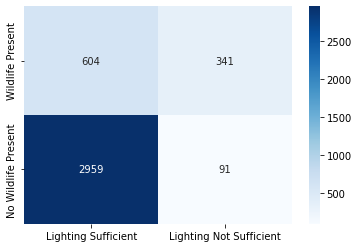


Number of training photos: 2996
Number of testing photos: 999
Number of lighting sufficient testing photos: 891
Number of lighting insufficient testing photos: 108


In [10]:
present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_sufficient/"
]

present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_insufficient/"
]

not_present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_sufficient/",
]

not_present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_insufficient/",
]

num_classes = 2
batch_size = 2

training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set = get_data_sets(
    present_file_pathes_ls, 
    present_file_pathes_lis,
    not_present_file_pathes_ls,
    not_present_file_pathes_lis
)
training_loader, testing_loader, ls_testing_loader, lis_testing_loader = get_loaders(
    training_data_set, 
    testing_data_set, 
    ls_testing_data_set, 
    lis_testing_data_set, 
    batch_size
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [13]:
train_and_test_Faster_RCNN(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)


Training and Testing Faster R-CNN
labels: tensor([0, 1], device='cuda:0')
output: [{'boxes': tensor([[9.8525e+01, 0.0000e+00, 1.0695e+02, 5.3328e+00],
        [5.0470e+01, 0.0000e+00, 5.8287e+01, 6.1386e+00],
        [7.6426e+01, 1.2248e+02, 8.4075e+01, 1.4105e+02],
        [5.5864e+00, 1.2182e+02, 1.9954e+01, 1.4067e+02],
        [5.2016e+01, 0.0000e+00, 5.6147e+01, 5.5679e+00],
        [1.2374e+00, 7.8333e+00, 3.2937e+01, 4.2250e+01],
        [1.6593e+01, 1.2048e+02, 2.8145e+01, 1.4529e+02],
        [7.4189e+01, 1.1725e+02, 8.6683e+01, 1.3679e+02],
        [1.9228e+01, 0.0000e+00, 2.8884e+01, 5.3783e+00],
        [5.3585e+01, 1.1778e+02, 6.0655e+01, 1.3376e+02],
        [4.3839e+01, 0.0000e+00, 5.1387e+01, 6.4520e+00],
        [7.5069e+01, 1.1644e+02, 9.4374e+01, 1.5981e+02],
        [4.9242e+01, 1.1797e+02, 6.2367e+01, 1.3510e+02],
        [2.5807e+01, 1.3050e+02, 4.2822e+01, 1.4869e+02],
        [2.0372e+01, 1.2780e+02, 3.7074e+01, 1.4756e+02],
        [1.7224e+01, 1.1339e+02, 4.7

TypeError: ignored

In [ ]:
#TODO: Get these working
#train_and_test_YOLO(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)
#train_and_test_SSD(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)